<a href="https://colab.research.google.com/github/evroth/Congressional_Analytics/blob/main/Congressional_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypothesis:
Districts with Democratic Representatitves will have more starbucks per person than the Districts with a Republican Representative. Big cities or metropolitan areas have more people and tend to lean liberal. We think they will contain a higher concentration of Starbucks locations per individual. With this analysis, we want to look at these ratios to see if it is consistently higher for blue districts than red.


## About:

This document contais the content for our first project in the Cloud Computing Class. The analysis below goes attempts to look at the number of starbucks locations per person in each congressional district, then look at whether the district is led by a Republican or Democrat.

We will gather data for Starbucks locations off of Kaggle (Feb 2017, https://www.kaggle.com/datasets/starbucks/store-locations?resource=download).

Census data from Census.gov for Total Population, District Number, and State (https://www.census.gov/data/developers/data-sets/acs-1year.html). All data from the year 2017.

Lastly data from some source on Political Affiliation, State, and District Number(https://data.opendatasoft.com/api/explore/v2.1/catalog/datasets/us-115th-congress-members@public/exports/json?lang=en&timezone=America%2FLos_Angeles). This is a json file found online for the information of the 115th congress, which took office in 2017.

We will do some EDA and merge the datasets together to perform our analysis.
The initial shape file I found is from https://cdmaps.polisci.ucla.edu/.


## Starbucks Stores per District
The first step here will be to get our data on Starbucks locations, note that you will need to download this file from Kaggle to the files colab can access for this to work. 

The file to run this code is located in the repository if needed.

In [1]:
# starbucks locations
## I am not sure how to always have this data downloaded, might need to re-upload it to colab every time?
import pandas as pd
from geopy.geocoders import Nominatim

# read store location data into a dataframe
store_df = pd.read_csv("starbucks_locations.csv")

# select only US stores
store_df = store_df[store_df['Country'] == "US"]

# Select the "Store Number", "State/Province", "Longitude", and "Latitude" columns
store_df = store_df[["Store Number", "State/Province", "Longitude", "Latitude"]]

# print the dataframe
print(store_df)

       Store Number State/Province  Longitude  Latitude
11964   3513-125945             AK    -149.78     61.21
11965   74352-84449             AK    -149.84     61.14
11966  12449-152385             AK    -149.85     61.11
11967  24936-233524             AK    -149.89     61.13
11968    8973-85630             AK    -149.86     61.14
...             ...            ...        ...       ...
25567   74385-87621             WY    -105.59     41.32
25568   73320-24375             WY    -105.56     41.31
25569  22425-219024             WY    -105.56     41.31
25570  10849-103163             WY    -109.25     41.58
25571  10769-102454             WY    -106.94     44.77

[13608 rows x 4 columns]


These next two chunks install libraries and download the zipfile for district shapes.

In [2]:
# Install Library
%%capture
!apt install libspatialindex-dev
!pip install rtree
!pip install geopandas
import geopandas as gpd

In [3]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = 'https://cdmaps.polisci.ucla.edu/shp/districts114.zip'

with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall()

Here we use geopandas to find what Congressional District each store is located in.

In [4]:
# Convert Lat and Long to Congressional Districts
import geopandas as gpd

# convert the store location data into a geodataframe
store_gdf = gpd.GeoDataFrame(store_df, geometry=gpd.points_from_xy(store_df.Longitude, store_df.Latitude))

# read congressional district data into a geodataframe
district_gdf = gpd.read_file("/content/districtShapes/districts114.shp")

# merge the store location data with the congressional district data
merged_gdf = gpd.sjoin(store_gdf, district_gdf, op='within')

# select only the columns we need
merged_gdf = merged_gdf[["Store Number", "State/Province", "STATENAME", "DISTRICT"]]

# print the merged data
merged_gdf.head(100)

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-4-9ea47f299da6>:11: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  merged_gdf = gpd.sjoin(store_gdf, district_gdf, op='within')


,Store Number,State/Province,STATENAME,DISTRICT
11964,3513-125945,AK,Alaska,0
11965,74352-84449,AK,Alaska,0
11966,12449-152385,AK,Alaska,0
11967,24936-233524,AK,Alaska,0
11968,8973-85630,AK,Alaska,0
...,...,...,...,...
12086,76606-101463,AL,Alabama,3
12087,9738-97528,AL,Alabama,3
12023,24427-237908,AL,Alabama,7
12024,18675-189964,AL,Alabama,7


The code below renames districts labeled as 0 to 1 to match the other data and rename some columns for the later merge.

In [5]:
merged_gdf['DISTRICT'] = merged_gdf['DISTRICT'].replace('0','1')
merged_gdf.head(100)

,Store Number,State/Province,STATENAME,DISTRICT
11964,3513-125945,AK,Alaska,1
11965,74352-84449,AK,Alaska,1
11966,12449-152385,AK,Alaska,1
11967,24936-233524,AK,Alaska,1
11968,8973-85630,AK,Alaska,1
...,...,...,...,...
12086,76606-101463,AL,Alabama,3
12087,9738-97528,AL,Alabama,3
12023,24427-237908,AL,Alabama,7
12024,18675-189964,AL,Alabama,7


In [6]:
merged_gdf.shape

(13443, 4)

The code below shows a count of Starbucks locations by state, ranked from greatest to least. Numbers are from Feb 2017.

In [7]:
merged_gdf['STATENAME'].value_counts()

California        2800
Texas             1041
Washington         751
Florida            680
New York           632
Illinois           573
Arizona            489
Colorado           481
Virginia           434
Ohio               378
Oregon             359
Pennsylvania       357
North Carolina     337
Georgia            326
Michigan           283
Massachusetts      272
Maryland           257
New Jersey         256
Nevada             252
Indiana            221
Minnesota          184
Missouri           183
Tennessee          181
Wisconsin          145
South Carolina     131
Connecticut        123
Kentucky           115
Utah               102
Kansas              99
Hawaii              91
Iowa                89
Alabama             85
Louisiana           84
Oklahoma            79
New Mexico          76
Idaho               67
Nebraska            58
Arkansas            55
Alaska              49
Montana             36
Mississippi         30
Maine               29
New Hampshire       27
Rhode Islan

From Scraphero.com (https://www.scrapehero.com/location-reports/Starbucks-USA/). The table below shows us a current count of starbucks locations (as for Jan 2023) so we can get a sense of if the numbers we got for 2017 are accurate.

In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Make a GET request to the URL
url = "https://www.scrapehero.com/location-reports/Starbucks-USA/"
res = requests.get(url)

# Parse the HTML content of the page
soup = BeautifulSoup(res.content, "html.parser")

# Find the table in the HTML
table = soup.find("table")

# Extract the data from the table
data = []
for row in table.find_all("tr"):
    cols = row.find_all("td")
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])

# Clean the data and create a pandas DataFrame
cleaned_data = []
for row in data:
    state = row[0].strip()
    store_count_text = row[1].strip()
    store_count = store_count_text.split(" ")[0].strip()
    cleaned_data.append([state, store_count])
df = pd.DataFrame(cleaned_data, columns=["State", "Store Count"])

print(df)


        State  Store Count
0  California  3,045 (19%)
1       Texas   1,324 (8%)
2     Florida     829 (5%)
3  Washington     743 (5%)
4    New York     688 (4%)
5    Illinois     660 (4%)
6     Arizona     556 (4%)
7    Colorado     497 (3%)
8    Virginia     487 (3%)
9        Ohio     478 (3%)


In [9]:
store_count = merged_gdf.groupby(['STATENAME', 'DISTRICT']).size().reset_index()
store_count.head()

,STATENAME,DISTRICT,0
0,Alabama,1,15
1,Alabama,2,7
2,Alabama,3,10
3,Alabama,4,2
4,Alabama,5,15


In [10]:
store_count = store_count.rename(columns={'STATENAME': 'State', 'DISTRICT': 'district number', 0: 'Store Count'})
store_count = store_count.astype({'district number':'int'})
store_count.head()

,State,district number,Store Count
0,Alabama,1,15
1,Alabama,2,7
2,Alabama,3,10
3,Alabama,4,2
4,Alabama,5,15


In [ ]:
#store_count.to_csv("store_count.csv")

## ASC 2017 Data

The next step is to read in the ACS 2017 data and format it into a usuable table.

In [11]:
# first some initial setup of libraries we will be using
import pandas as pd # this is the main library used in python for manipulating data. 
import json # this is a library to parse json (javascript object notation)
from urllib.request import urlopen # library to read data from a URL
import matplotlib.pyplot as plt # visualization library we will use that integrates with pandas

In [12]:
# We are reading in the data we want from ACS 2017. The API returns json data. Try copy and pasting the link yourself in a browser to see what the raw data looks like.
url="https://api.census.gov/data/2017/acs/acs1?get=NAME,B01003_001E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here:
# https://api.census.gov/data/2017/acs/acs1/variables.html Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Total Population', 'State code', 'district number']

acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])
acs_df['district number'] = acs_df['district number'].replace(0,1)

acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['Total Population', 'district number', 'State']]

# take a look at the top results in the dataset
acs_df.head()

,Total Population,district number,State
0,713410,1,Alabama
1,673776,2,Alabama
2,710488,3,Alabama
3,685553,4,Alabama
4,718713,5,Alabama


## Party Affiliation Data
Party data from 115th congress, begining 2017

In [13]:
# We are reading in the data we want from United States 115th Congress via OpenData Soft. The API returns json data.
url1 = "https://data.opendatasoft.com/api/explore/v2.1/catalog/datasets/us-115th-congress-members@public/exports/json?lang=en&timezone=America%2FLos_Angeles"

# store the response of URL
response1 = urlopen(url1)

# storing the JSON response from url in data
data1_json = json.loads(response1.read())

party_df = pd.DataFrame(data1_json)

# take a look at the top results in the dataset
party_df.head()

# time to do some basic cleanup of the data.
party_df = party_df.query("rep_sen == 'Representative'")

# Let's just keep the columns we need
party_df = party_df[['state_label','district','party','rep_sen']]

# take a second look at the top results in the dataset
party_df

,state_label,district,party,rep_sen
0,Alabama,07,Democratic,Representative
1,California,01,Republican,Representative
2,California,17,Democratic,Representative
3,Florida,17,Republican,Representative
4,Florida,24,Democratic,Representative
...,...,...,...,...
537,New York,01,Republican,Representative
538,North Carolina,02,Republican,Representative
540,Ohio,04,Republican,Representative
542,Oregon,03,Democratic,Representative


In [14]:
party_df = party_df.rename(columns={'state_label': 'State', 'district': 'district number'})
party_df = party_df.drop(columns=['rep_sen'])
party_df = party_df.astype({'district number':'int'})
party_df['district number'] = party_df['district number'].replace(0,1)
party_df.head()

,State,district number,party
0,Alabama,7,Democratic
1,California,1,Republican
2,California,17,Democratic
3,Florida,17,Republican
4,Florida,24,Democratic


## Merge the Data

In [15]:
combined_df = pd.merge(acs_df, party_df, on=["State", "district number"])
combined_df = pd.merge(combined_df, store_count,on=["State", "district number"])
combined_df = combined_df.astype({'Total Population':'int'})
combined_df.head(10)

,Total Population,district number,State,party,Store Count
0,713410,1,Alabama,Republican,15
1,673776,2,Alabama,Republican,7
2,710488,3,Alabama,Republican,10
3,685553,4,Alabama,Republican,2
4,718713,5,Alabama,Republican,15
5,700401,6,Alabama,Republican,23
6,672406,7,Alabama,Democratic,13
7,739795,1,Alaska,Republican,49
8,765810,1,Arizona,Democratic,39
9,720429,2,Arizona,Republican,56


In [18]:
combined = combined_df
combined_df['stores_per_100k'] = 100000*(combined_df['Store Count'] / combined_df['Total Population'])
combined_df.head(50)

,Total Population,district number,State,party,Store Count,stores_per_100k
0,713410,1,Alabama,Republican,15,2.102578
1,673776,2,Alabama,Republican,7,1.038921
2,710488,3,Alabama,Republican,10,1.407483
3,685553,4,Alabama,Republican,2,0.291735
4,718713,5,Alabama,Republican,15,2.087064
5,700401,6,Alabama,Republican,23,3.283833
6,672406,7,Alabama,Democratic,13,1.933356
7,739795,1,Alaska,Republican,49,6.623456
8,765810,1,Arizona,Democratic,39,5.092647
9,720429,2,Arizona,Republican,56,7.773146


## Visual Analysis

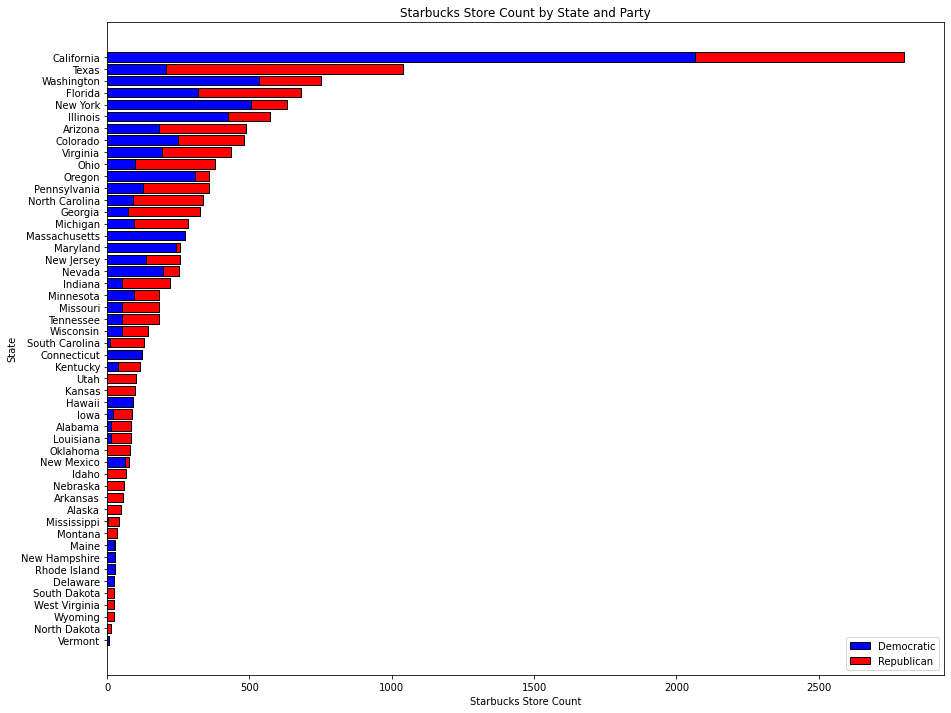

In [19]:
# Let's just keep the columns we need
combined = combined[['State', 'party', 'Store Count']]

# Use the groupby method to group the data by 'State' and 'party'
combined = combined.groupby(['State', 'party']).sum()

# Reset the index to make 'State' and 'party' columns
combined = combined.reset_index()

# pivot
pivot = combined.pivot_table(index='State', columns='party', values='Store Count')

# Get the Sum
pivot['Total'] = pivot.sum(axis=1)

# assign row num
pivot = pivot.reset_index().fillna(0).sort_values('Total')

# Print the new table
pivot.head(50)

# Create a bar chart
plt.subplots(figsize=(15, 12))
plt.barh(pivot["State"], pivot["Democratic"], color='blue', edgecolor='black', label='Democratic')
plt.barh(pivot["State"], pivot["Republican"], color='red', left=pivot["Democratic"], edgecolor='black', label = 'Republican')


# Add labels and title to the chart
plt.ylabel("State")
plt.xlabel("Starbucks Store Count")
plt.title("Starbucks Store Count by State and Party")

# Add the legend and set the location to the bottom right corner
plt.legend(loc="lower right")

# Show the chart
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

In [ ]:
# Data type conversions
df = combined_df[['party', 'stores_per_100k']].copy()
df['party'] = combined_df['party'].astype(object)
df['stores_per_100k'] = df['stores_per_100k']
df.head(100)

,party,stores_per_100k
0,Republican,2.102578
1,Republican,1.038921
2,Republican,1.407483
3,Republican,0.291735
4,Republican,2.087064
...,...,...
95,Democratic,2.416724
96,Democratic,4.819196
97,Republican,1.428360
98,Republican,2.181862


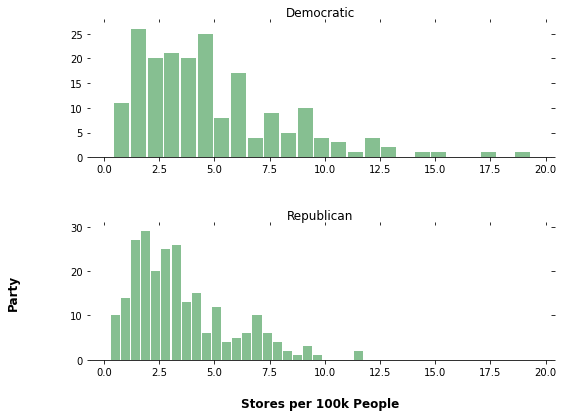

In [ ]:
ax = df.hist(column='stores_per_100k', by='party', bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#86bf91', zorder=2, rwidth=0.9)

for i,x in enumerate(ax):

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Set x-axis label
    x.set_xlabel("Stores per 100k People", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    if i == 1:
        x.set_ylabel("Party", labelpad=50, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    x.tick_params(axis='x', rotation=0)

In [23]:
combined_df_xtra = combined_df[['State','party','Store Count','stores_per_100k']]

result = combined_df_xtra.groupby(['State', 'party']).agg({'Store Count': 'sum', 'stores_per_100k': 'mean'})
result = result.unstack()
result.columns = ['_'.join(col).strip() for col in result.columns.values]
result = result.reset_index()

result = result.fillna(0)

In [24]:
print(result.to_markdown())

|    | State          |   Store Count_Democratic |   Store Count_Republican |   stores_per_100k_Democratic |   stores_per_100k_Republican |
|---:|:---------------|-------------------------:|-------------------------:|-----------------------------:|-----------------------------:|
|  0 | Alabama        |                       13 |                       72 |                     1.93336  |                     1.70194  |
|  1 | Alaska         |                        0 |                       49 |                     0        |                     6.62346  |
|  2 | Arizona        |                      182 |                      307 |                     5.83318  |                     7.91602  |
|  3 | Arkansas       |                        0 |                       55 |                     0        |                     1.7853   |
|  4 | California     |                     2064 |                      736 |                     7.08536  |                     7.03335  |
|  5 | Colorado     

In [ ]:
from scipy.stats import ttest_ind

# Separate the data into two groups based on the 'party' column
republican = df[df['party'] == 'Republican']['stores_per_100k']
democratic = df[df['party'] == 'Democratic']['stores_per_100k']

# Perform the t-test
t_statistic, p_value = ttest_ind(republican, democratic)

# Print the results
print("t-statistic: ", t_statistic)
print("p-value: ", p_value)

t-statistic:  -5.25673188598282
p-value:  2.3077042768343574e-07


## Results
From the graphs and our low p-value, we can see that our hypothesis is on the right track. That is there is statistically significant evidence to reject the null that there is no difference between the number of stores per person in Democratic and Republican congression districts. Although the Republican and Democrat districts follow roughly similar districutions, a few outlier blue districts make the Democratic distribution skewed right and leads us to our conclusion that there is a differece between the two.